# Железничар Баес

### Краток опис

Во оваа дигитална тетратка е прикажан пример за робот кој се движи по шини кои се поврзани кружно. Примерот служи за објаснување на основните концепти кај Баесовиот филтер.

In [1]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import plotly.offline as pl
import plotly.graph_objs as go

Во класата `Railman` е вметната физиката на движењето и мерењето податоци кај нашиот робот кој се движи по кружна патека.

In [2]:
class Railman():
    def __init__(self, track_len, kernel=[1.]):
        self.track_len = track_len
        self.position = 0
        self.kernel = kernel

    def move(self, distance=1):
        offset_array = np.arange(len(kernel)) - len(kernel) // 2        
        offset = np.random.choice(offset_array, p=kernel)
        self.position = int((self.position + distance + offset) % self.track_len)
        return self.position
    
    def sense(self):
        array_p = []
        for i in range(self.track_len):
            if i == self.position:
                z = np.random.choice(['here', 'not here'], p=[0.8, 0.2])
            else:
                z = np.random.choice(['here', 'not here'], p=[0.1, 0.9])
            if z == 'here':
                p = (9 * 0.9 + 1 * 0.8) / 10
            else:
                p = (9 * 0.1 + 1 * 0.2) / 10
            array_p.append(p)
        return np.array(array_p)

За почеток нашата кружна патека ја делиме на 10 еднакви делови кои ги броиме почнувајќи од 0 па до 9. Роботот сметаме дека секогаш се наоѓа на патеката, на тие 10 полиња. Роботот може да се движи по шините, а неговата позиција на шините ја моделираме како цел број mod бројот на полиња. При секое придвижување роботот може да измести и да заврши на друга позиција. На пример, роботот се наоѓа на позиција 0 и му даваме наредба да се придвижи едно поле нанапред. Тој се придвижува едно поле, но при тоа придвижување можно е да се измести едно поле нанапред или едно поле наназад. Во овој пример моделирано е роботот да застане на посакуваната позиција со `0.7` веројатност. Постои `0.2` веројатност дека нема да го изврши тој чекор, а постои `0.1` веројатност дека роботот ќе ја надмине посакуваната позиција.

Правиме симулација на движењето на роботот. На графикот можеме да видиме како позицијата се менува со текот на времето. Забележете ги рамните сегменти каде роботот всушност не направил чекор, и пострмните делови каде роботот ја надминал посакуваната позиција.

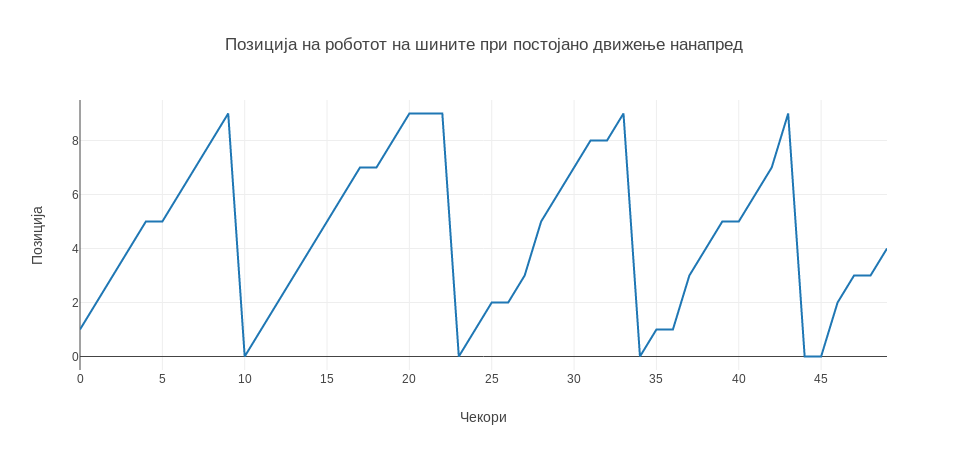

In [3]:
track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

kernel = [.2, .7, .1]
robot = Railman(len(track))
robot_history = []
for _ in range(50):
    robot.move(distance=1)
    robot_history.append(robot.position)

data = [go.Scatter(y=robot_history)]
pl.iplot({'data': data, 'layout': {'title': 'Позиција на роботот на шините при постојано движење нанапред',
                                   'xaxis': {'title': 'Чекори'},
                                   'yaxis': {'title': 'Позиција'}}})

Ајде да видиме како нашето верување за позицијата на роботот ќе се менува со тек на времето кога ќе се движи роботот по шините. Почнуваме со информација дека роботот се наоѓа на позција `5`.

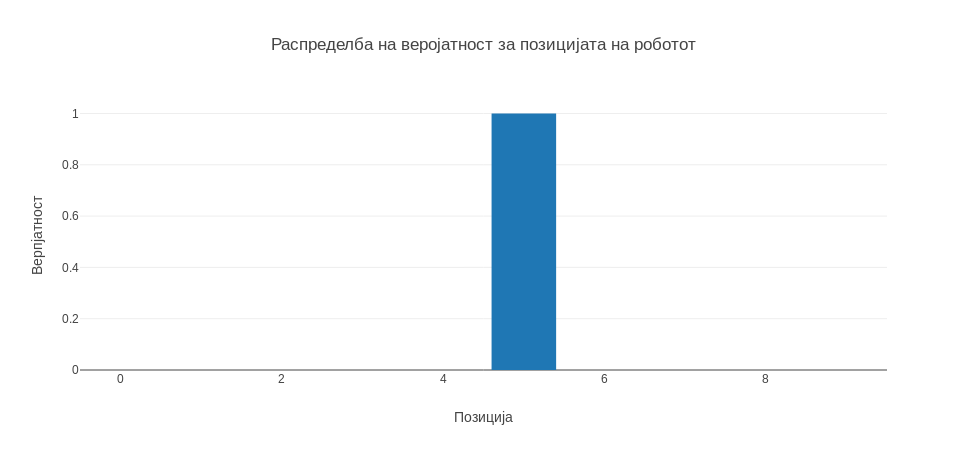

In [4]:
belief = [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
data = [go.Bar(y=belief)]
pl.iplot({'data': data, 'layout': {'title': 'Распределба на веројатност за позицијата на роботот',
                                   'xaxis': {'title': 'Позиција'},
                                   'yaxis': {'title': 'Верпјатност'}}})

Сега правиме чекор напред. Веќе го моделиравме системот дека греши при придвижувањето, па истата информација ќе ја искористиме за моделирање на нашето верување каде се наоѓа роботот по придвижувањето. Ако моментално е на позиција `5`, и земајќи ги во пресметките грешките кои роботот ги прави при придвужување, доаѓаме до заклучок дека роботот сега треба да се наоѓа на позиција `6` со веројатност `0.7`. Можно е да не го изврши тој чекор и со `0.2` веројатност да остане на позиција `5`, а можно е да направи уште еден чекор и со веројатност `0.1` да застане на позиција `7`.

In [5]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prediction = np.zeros(n)
    for i in range(n):
        prediction[i] = belief[(i-move) % n] * p_correct + belief[(i-move-1) % n] * p_over + belief[(i-move+1) % n] * p_under
    return prediction

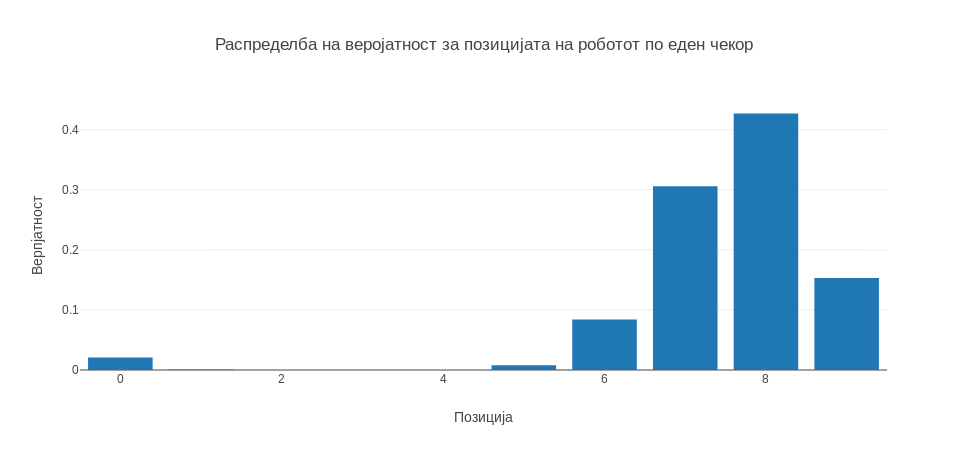

In [8]:
belief = predict_move(belief, 1, .2, .7, .1)
data = [go.Bar(y=belief)]
pl.iplot({'data': data, 'layout': {'title': 'Распределба на веројатност за позицијата на роботот по еден чекор',
                                   'xaxis': {'title': 'Позиција'},
                                   'yaxis': {'title': 'Верпјатност'}}})

Во функцијата `predict_move()` и на програмерски начин го моделиравме верувањето кое го имаме по придвижување на роботот. Клучна работа да забележете е начинот на кој со текот на времето се губи нашата сигурност каде роботот навистина се наоѓа. Слободно извршете ја горната ќелија неколку пати и внимателно пратете ја распределбата на веројатност. По 100 чекори толку многу ќе се влоши нашето верување, што всушност значи дека со сигурност можеме да изјавиме дека не знаме каде роботот се наоѓа. Симулацијата за 100 чекори ја има на следниот график.

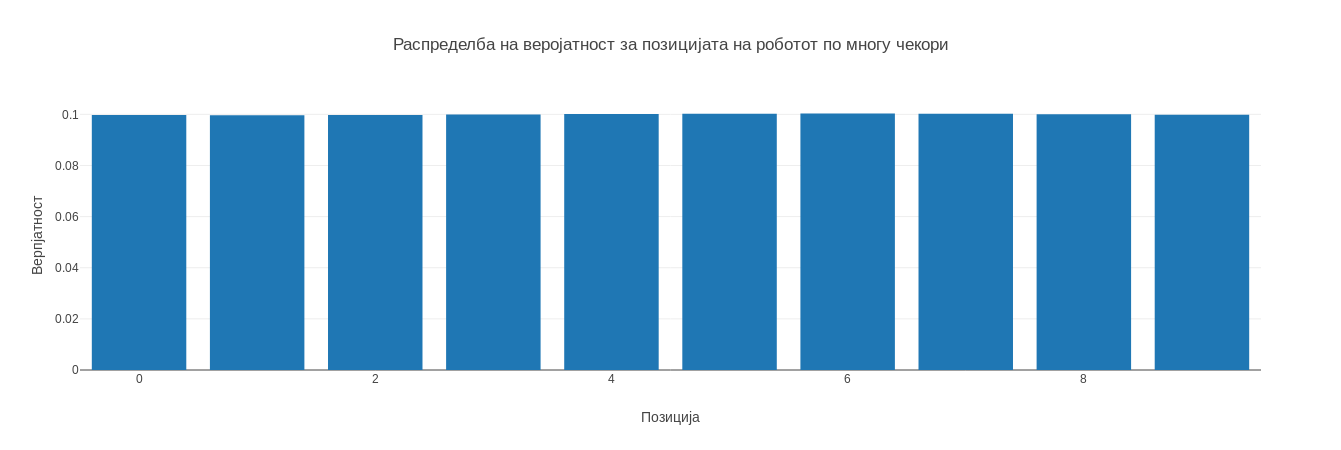

In [45]:
for _ in range(100):
    belief = predict_move(belief, 1, .2, .7, .1)
data = [go.Bar(y=belief)]
pl.iplot({'data': data, 'layout': {'title': 'Распределба на веројатност за позицијата на роботот по многу чекори',
                                   'xaxis': {'title': 'Позиција'},
                                   'yaxis': {'title': 'Верпјатност'}}})

Оваа постапка всушност е математичката операција [конволуција](https://en.wikipedia.org/wiki/Convolution). Генерално, конволуцијата опишува како една функција може да влијае и изобличи друга функција. Во нашиот пример роботот се движи, а ние пресметуваме верување за негова неговата позиција. При секој чекор ја моделираме веројатноста тој да направи грешка, а изобличувањето на нашето верување со веројатноста за грешка е всушност конволуција. Генерално, равенката е 
$$ (f*g)(t) = \int_{-∞}^{∞} f(\tau) g(t-\tau) d\tau$$
а во дискретен домен
$$ (f*g)[n] = \sum_{m=-∞}^{∞} f[m] g[n-m] $$
Ова значи дека $f$ е функцијата која ќе биде изобличена со функцијата $g$ која се нарекува кернел. Кај нашиот пример, функцијата $f$ е нашето верување кое го изобличуваме со веројатноста за грешка. Таа веројатност за грешка можеме да ја склопиме во една низа $\begin{bmatrix} 0.2 & 0.7 & 0.1 \end{bmatrix}$, а ќе ја нарекуваме кернел. Подолу е редизајнирана функцијата `predict_move()` во `predict_move_convolution()`, овојпат користејќи ја терминологијата и обопштувањето од теоријата на коволуцијата.

![Конволуција](images/Convolution.png "Конволуција")


Еве пример како тоа би работело на нашиот случај.
Кернелот $\begin{bmatrix} x & y & z \end{bmatrix} = \begin{bmatrix} 0.2 & 0.7 & 0.1 \end{bmatrix}$ го превртуваме и добиваме $ \begin{bmatrix} z & y & x \end{bmatrix} = \begin{bmatrix} 0.1 & 0.7 & 0.2 \end{bmatrix}$. Заменуваме со букви за полесно претставување.

Нека почетната позиција на роботот е 5.

    0    0    0    0    0    1    0    0    0    0

Ќе го земеме нашиот кернел $\begin{bmatrix} z & y & x \end{bmatrix}$ ќе го лизгаме од лево на десно, ќе ги измножиме елементите кои се преклопуваат и ќе ги собереме. По конволуцијата се добива
    
    0    0    0    0    .2   .7   .1   0    0    0

Дополнително треба да ја поместиме низата во десно бидејќи роботот се движи во таа насока. По првата итерација се добива

    0    0    0    0    0    .2   .7   .1   0    0

Наредната конволуција + поместување поради движењето на роботот ќе ја произведат следната низа

    0    0    0    0    0   .04  .28  .53  .14  .01

За понатамошните вредности извршете ја симулацијата во наредните графици.

Да не ве буни тоа што кернелот го превртуваме. Постои постапка која се нарекува корелација, а речиси е иста како конволуцијата. Разликата е дали кернелот ќе се преврти или не. Во нашиот случај кернелот го првртуваме бидејќи така работи физиката на нашиот робот. Ако не го превртевме кернелот по првата итерација ќе добиевме

    0    0    0    0    .1   .7   .2   0    0    0
    
што не се совпаѓа со нашето првично моделирање како се движи роботот.



In [46]:
def predict_move_convolution(pmf, kernel, distance):
    """
    Predict the next move. Convolve the pmf with the kernel. The modulo operation is implemented to account for the circular path.
    pmf: probability mass function
    kernel: kernel for the convoluton
    distance: distance to travel
    """
    
    n = len(pmf)
    kn = len(kernel)
    width = kn // 2
    convolved = np.zeros(n)
    for i in range(n):
        for k in range (kn):
            index = (i + (width-k) - distance) % n
            convolved[i] += pmf[index] * kernel[k]
    return convolved

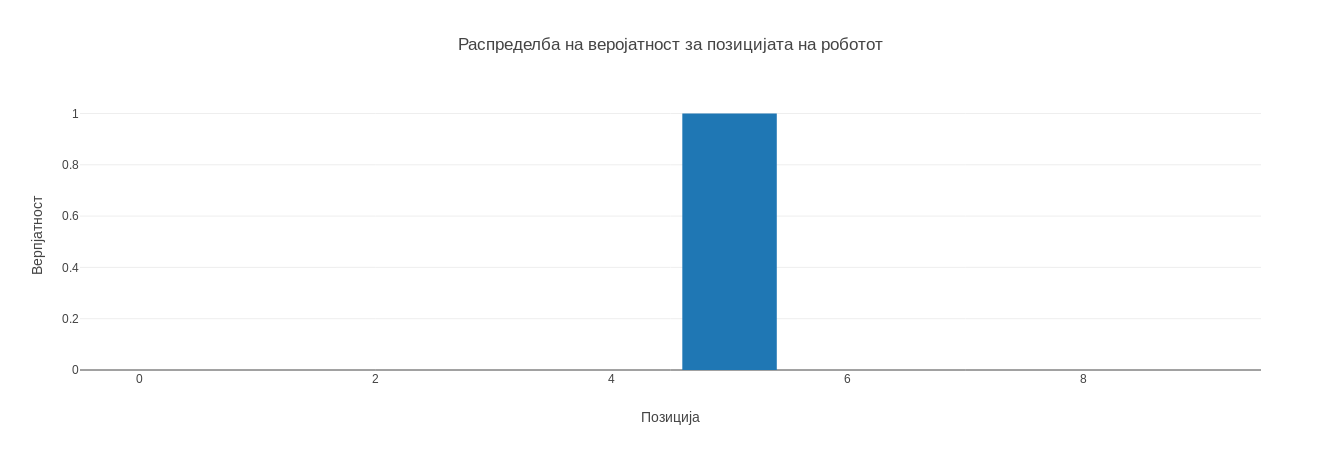

In [47]:
belief = [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
data = [go.Bar(y=belief)]
pl.iplot({'data': data, 'layout': {'title': 'Распределба на веројатност за позицијата на роботот',
                                   'xaxis': {'title': 'Позиција'},
                                   'yaxis': {'title': 'Верпјатност'}}})

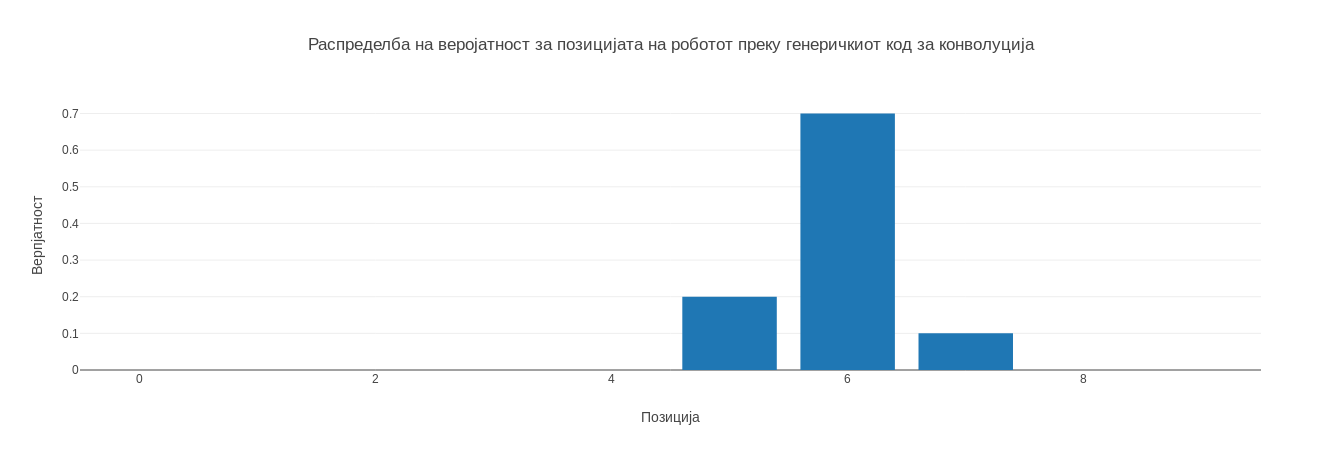

In [48]:
prediction = predict_move_convolution(belief, [.2, .7, .1], 1)
data = [go.Bar(y=prediction)]
pl.iplot({'data': data, 'layout': {'title': 'Распределба на веројатност за позицијата на роботот преку генеричкиот код за конволуција',
                                   'xaxis': {'title': 'Позиција'},
                                   'yaxis': {'title': 'Верпјатност'}}})

Конволуцијата е пресметковно сложена задача за пресметување. За да добиеме на брзина најлесно е да искористиме готов код од библиотеките на scipy. Постои функција `convolve1d()` која ја врши истата задача како нашиот код погоре. Треба да се вклучи движењето на роботот бидејќи `convolve1d()` ќе ја пресмета само конволуцијата. Дополнително, треба да се постави начинот за справување со граничните случаи. Бидејќи нашиот робот се врти во круг, потребно е да начинот за справување со граничните случаи да го поставиме на [wrap](https://en.wikipedia.org/wiki/Wrap_(food)). За останатите начини ќе си прочитате повеќе во [документацијата](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html). 

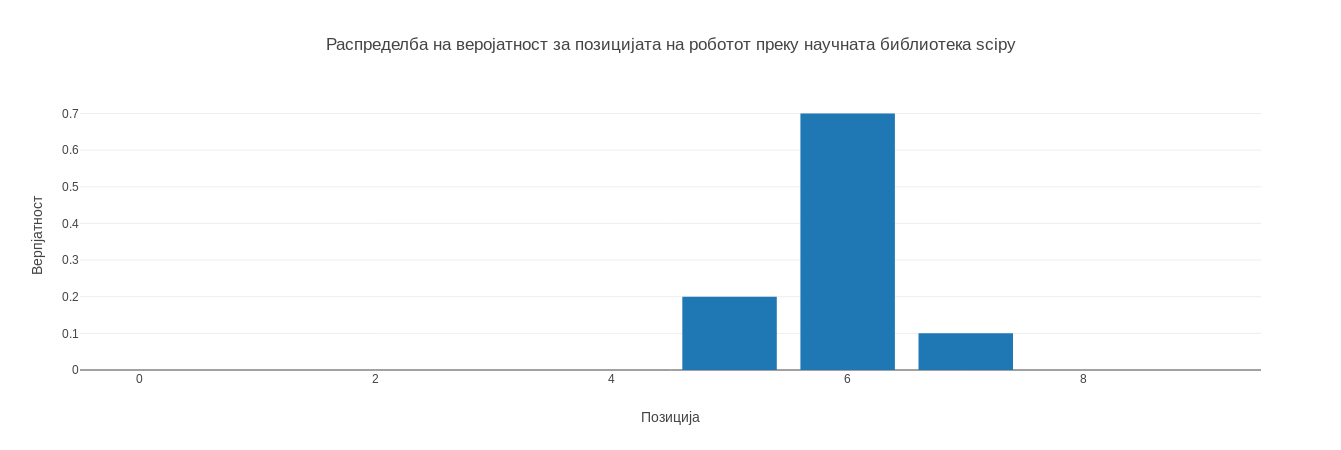

In [81]:
prediction = ndimage.filters.convolve1d(np.roll(belief, 1), [.2, .7, .1], mode='wrap')
data = [go.Bar(y=prediction)]
pl.iplot({'data': data, 'layout': {'title': 'Распределба на веројатност за позицијата на роботот преку научната библиотека scipy',
                                   'xaxis': {'title': 'Позиција'},
                                   'yaxis': {'title': 'Верпјатност'}}})

Сега на ред земањето на информација од сензорите. Во зависност од природата на сензорот, различно ќе ја моделираме веројатноста за мерењето. Да претпоставиме дека имаме по еден сензор за секое од 10-те полиња. Нека природата на сензорот вели
    $$ p(z=\text{"here"} | x = \text{"there"}) = 0.7 $$
    $$ p(z=\text{"not here"} | x = \text{"there"}) = 0.3 $$
    $$ p(z=\text{"here"} | x = \text{"not there"}) = 0.1 $$
    $$ p(z=\text{"not here"} | x = \text{"not there"}) = 0.9 $$

Овие податоци треба да ги обликуваме во веројатност од мерењето каде се наоѓа роботот. Ова е веќе имплементирано во функцијата `sense()` во класата `Railman`.

Понатаму, ќе направиме симулација на Баесовиот филтер следејќи ги стандардните чекори.
1. Правиме чекор со роботот
* Правиме предвидување на позицијата на роботот
* Земаме информации од сензорите
* Ги спојуваме предвидувањето и информацијата од сензорите за да добиеме ново верување

Резултатите се прикажани во форма на слика за секоја итерација.

Вистинската позиција е: 1


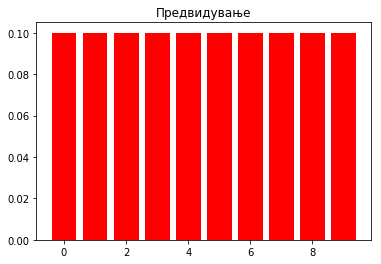

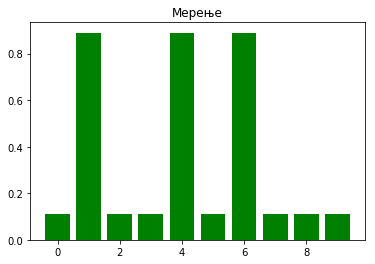

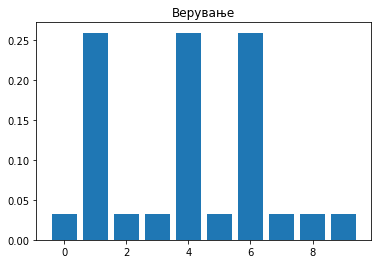

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 2


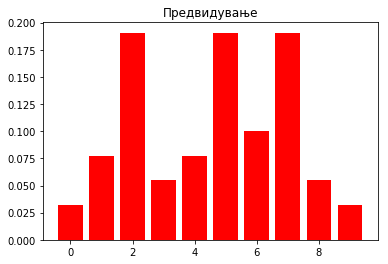

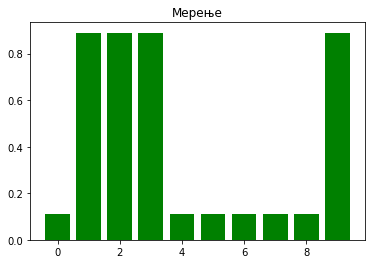

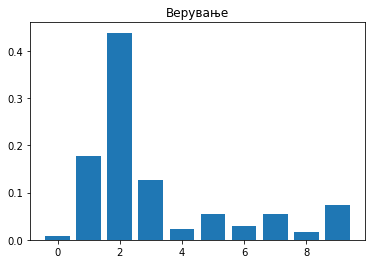

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 3


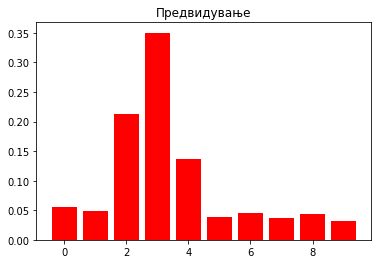

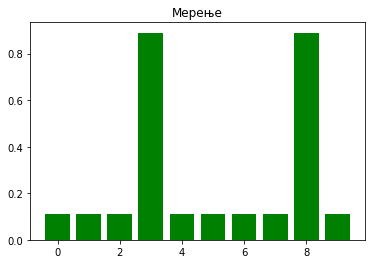

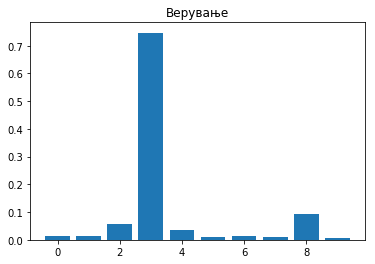

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 4


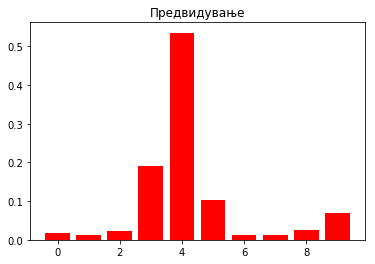

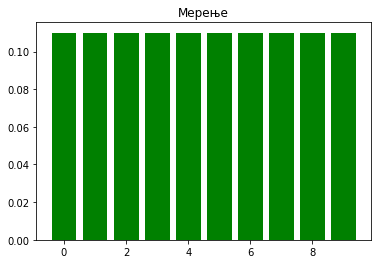

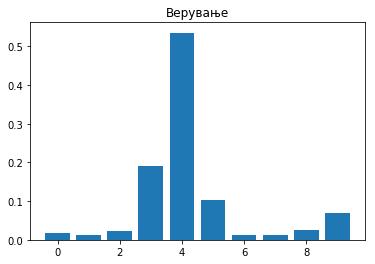

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 5


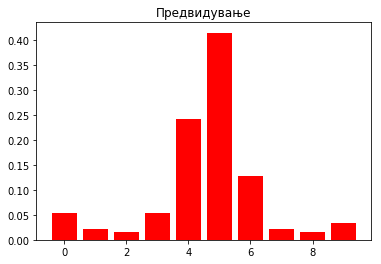

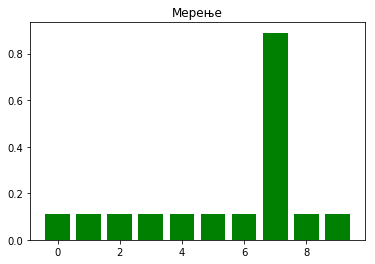

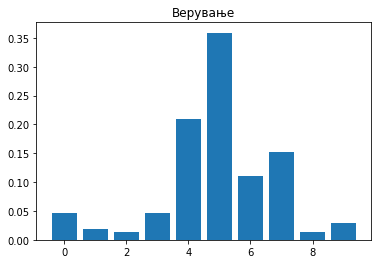

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 7


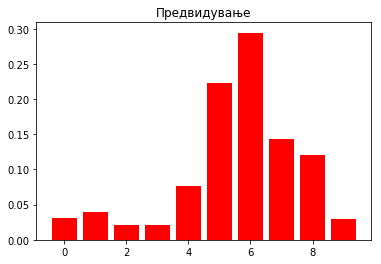

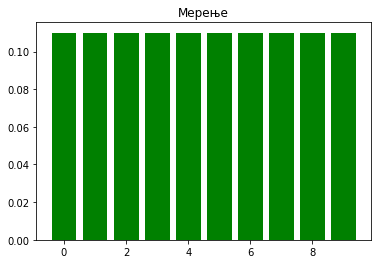

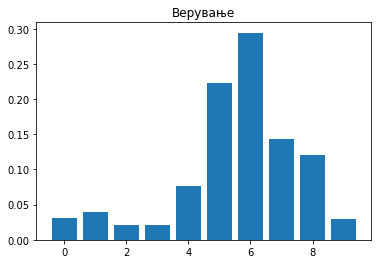

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 9


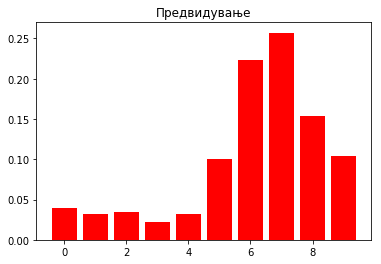

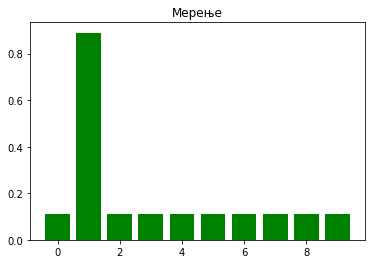

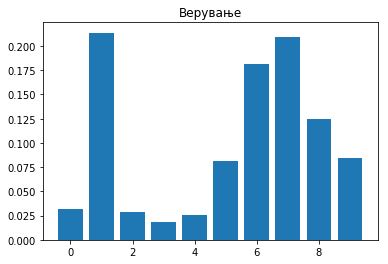

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 0


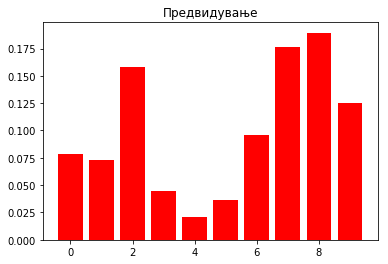

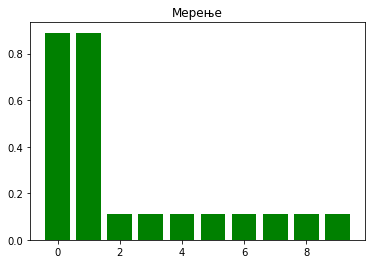

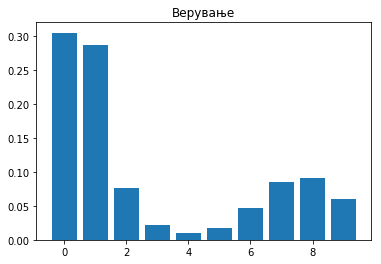

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 1


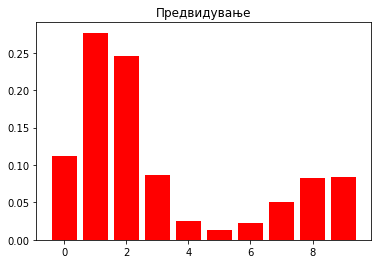

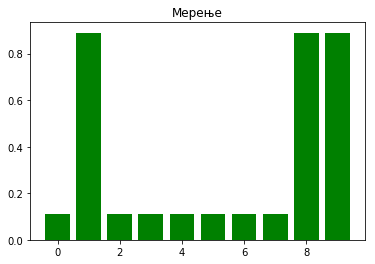

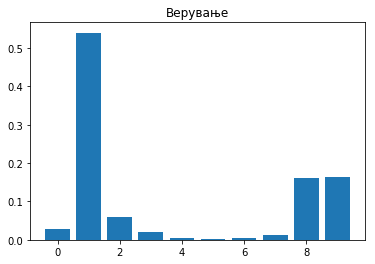

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 2


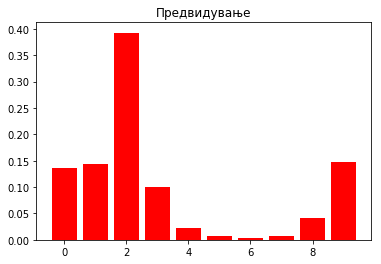

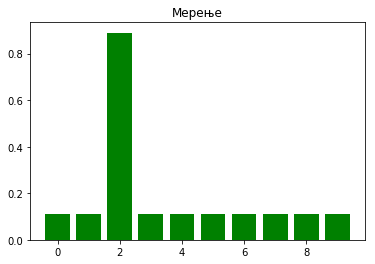

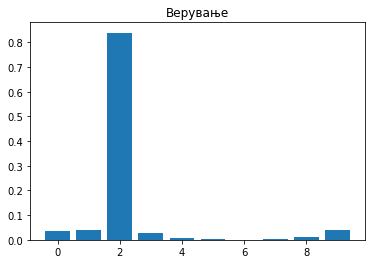

-------------------------------------------------------------------------------------------------


In [82]:
track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# belief = np.array([.9] + [0.01]*9)
belief = np.ones_like(track)
belief = belief / belief.sum()
kernel = [0.2, 0.7, 0.1]
r = Railman(len(track))
for i in range(10):
    u = 1
    r.move(u)
    print('Вистинската позиција е: {}'.format(r.position))
    
    prediction = predict_move_convolution(belief, kernel, u)       
    plt.bar(range(len(prediction)), prediction, color='r') 
    plt.title('Предвидување')
    plt.show()
    
    likelihood = r.sense()
    plt.bar(range(len(likelihood)), likelihood, color='g') 
    plt.title('Мерење')
    plt.show()
    
    belief = likelihood * prediction
    belief = belief / belief.sum()
    plt.bar(range(len(belief)), belief) 
    plt.title('Верување')
    plt.show()
    print('-------------------------------------------------------------------------------------------------')

Во примерот можеме да видиме како работи Баесовиот филтер. Успешно се справува со проблемот за локализирање на роботот без информација за почетната позиција на роботот. Успешно се справува и со шумот од сензорот. 

Да не ве заведе во погрешна насока едноставноста на примерот. Ова е робусен филтер кој слободно може да се користи во реалноста. Но, постојат ограничувања кои го прават речиси некорисен.

Еден проблем е пресметковната сложеност која го прави овој филтер употреблив во реалноста само за елементарни примери. Во овој пример разгледавме следење на робот кој се движи во 1Д, а водевме сметка само за позицијата. Сите реални проблеми имаат потреба од следење далеку повеќе параметри. На пример, доколку правите систем за анализа на фудбалски натпревар, систем кој ќе ги следи играчите и топката од видео снимка. Тука има многу параметри за следење. Ако имаме само два параметри за следење тогаш нашата апроксимација на густината на веројатност ќе беше матрица. За $n$ параметри $n$-димензионална матрица. А пресметковната сложеност зависи експоненцијално од бројот на параметри.

Втор проблем е резолуцијата. Филтерот е дискретен, а светот континуален. Ако сакаме да пресметуваме со резолуција од 1 cm за играчите на фудбалски терен долг 100 m ќе треба да пресметуваме 10000 различни веројатности, само за една димензија. За да можеме да определиме каде ќе се наоѓа некој играч со резолуција од 1 cm^2 ќе треба да пресметуваме 1Е8 променливи. Доколку сакаме попрецизно да ја мериме позиција на роботот тогаш ќе треба да ја зголемиме резулуцијата преку воведување на повеќе состојби. Веќе ни е познато дека повеќе состојби значат повеќе време потрошено за пресметување.